# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

In [7]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

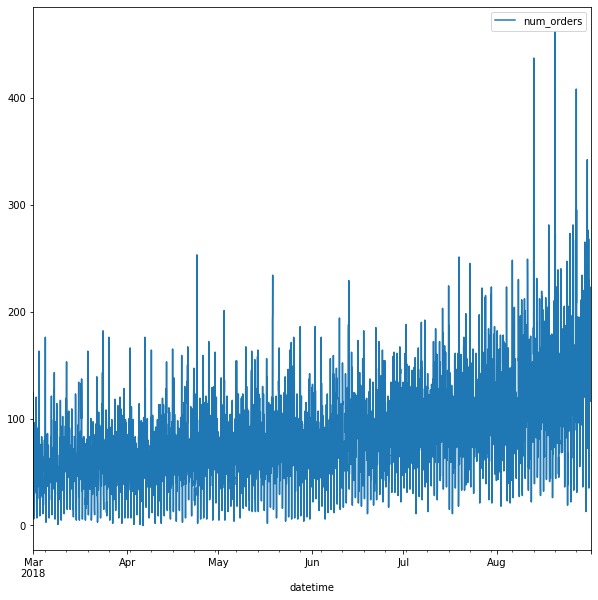

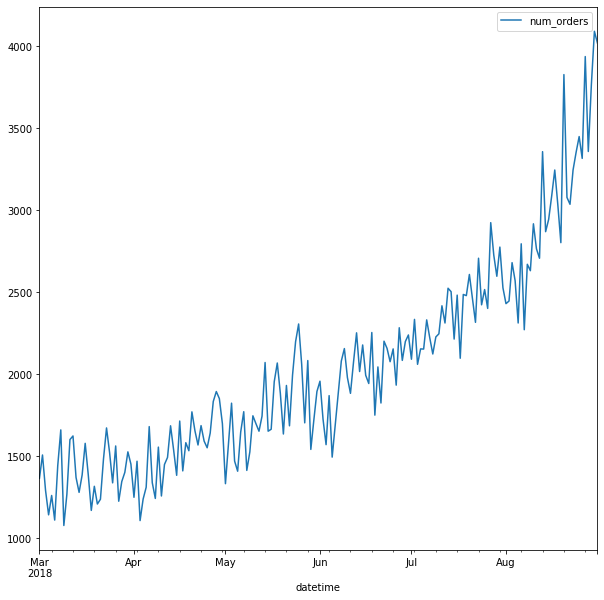

In [8]:
df.sort_index(inplace=True)
df_day = df.resample('1D').sum()
df_hours = df.resample('1H').sum()

df_hours.plot(figsize=(10,10))
df_day.plot(figsize=(10,10))


## Вывод

Данные состоят из 26496 строк, период наблюдений с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.  
Столбец с количеством заказов представлен с частотой наблюдений каждые 10 минут.  
Пропуски отсутствуют.
Судя по графику, количество заказов растет с начала наблюдений.


# 2. Анализ

In [9]:
decomposed_hours = seasonal_decompose(df_hours)
decomposed_day = seasonal_decompose(df_day)

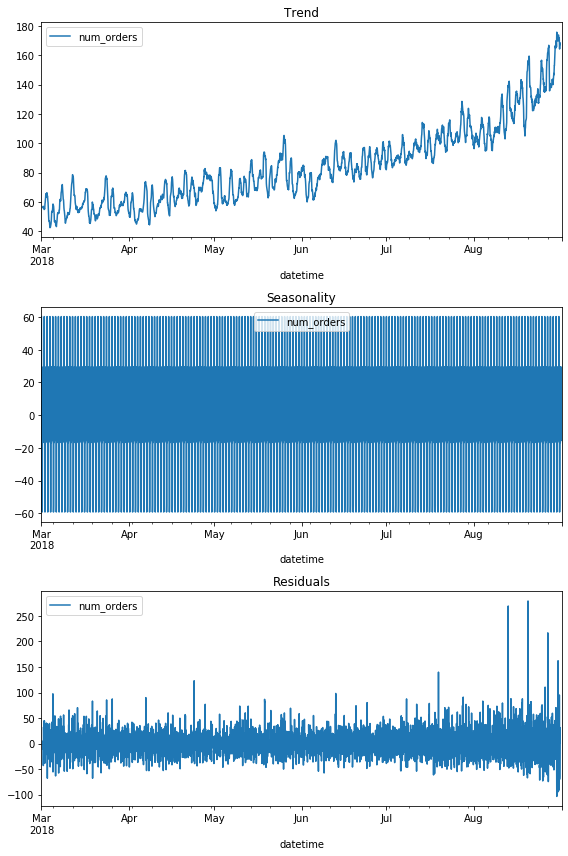

In [10]:
plt.figure(figsize=(8, 12))
plt.subplot(311)

decomposed_hours.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_hours.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_hours.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

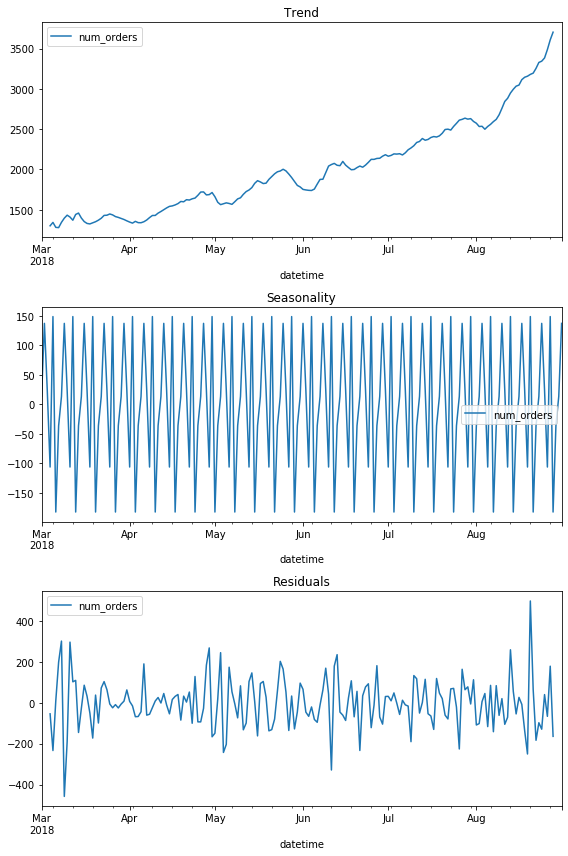

In [11]:
plt.figure(figsize=(8, 12))
plt.subplot(311)

decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Построим график сезонности на промежутке с 2018-07-30 по 2018-08-15 для сравнения распределения заказов по дням недели:

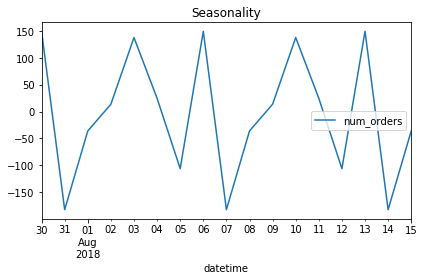

In [12]:
decomposed_day.seasonal['2018-07-30':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot()

plt.tight_layout()

In [13]:
import datetime
import calendar

mydate = "03.08.2018"

workdate = datetime.datetime.strptime(mydate, "%d.%m.%Y")
print(calendar.day_abbr[workdate.date().weekday()])

Fri


Как мы видим количество заказов максимально в пт и пн, а минимально во вт и вск.  
Результаты закономерны.

Построим график сезонности на промежутке с 2018-08-03 по 2018-08-04 для сравнения распределения заказов в сутках:

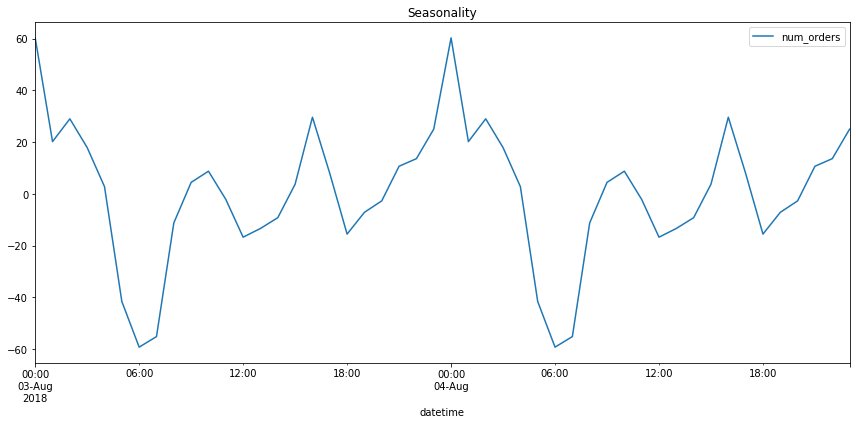

In [14]:
plt.figure(figsize=(12, 6))
decomposed_hours.seasonal['2018-08-03':'2018-08-04'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot()

plt.tight_layout()

Количество заказов максимально в 00:00 ночи и минимально в 06:00 утра. 

## Вывод

Прослеживается тренд на увеличение количества заказов.  
Количество заказов максимально в пт и пн, а минимально во вт и вск.  
Мы четко видим активность клиентов в течение рабочего дня и снижение в ночное время.

# Обучение

Создадим функцию `make_features` для создания признаков(календарных, отстающих значений и скользящее среднее):

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df['weekday'] = df.index.weekday
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

<b>Комментарий студента:</b>
Изначально в фичах не создал день недели, исправляюсь. В остальном было все так как ты описал. 
<br>   
</div>

Так как по условию задачи нужно спрогнозировать количество заказов такси на следующий час, используем для обучения данные сгруппированные по количеству заказов на каждый час:

In [16]:
make_features(df_hours, 7, 7)

train, test = train_test_split(df_hours, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3967 entries, 2018-03-01 07:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 11 columns):
weekday         3967 non-null int64
day             3967 non-null int64
hour            3967 non-null int64
lag_1           3967 non-null float64
lag_2           3967 non-null float64
lag_3           3967 non-null float64
lag_4           3967 non-null float64
lag_5           3967 non-null float64
lag_6           3967 non-null float64
lag_7           3967 non-null float64
rolling_mean    3967 non-null float64
dtypes: float64(8), int64(3)
memory usage: 371.9 KB


In [18]:
features_train.shape

(3967, 11)

In [19]:
state = np.random.RandomState(12345)

## LinearRegression

In [20]:
%%time
model = LinearRegression()

model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("RMSE обучающей выборки:", np.sqrt(mean_squared_error(target_train, pred_train)))

RMSE обучающей выборки: 31.32409043484747
CPU times: user 23.8 ms, sys: 9.48 ms, total: 33.3 ms
Wall time: 9.66 ms


In [21]:
tscv = TimeSeriesSplit(n_splits=3)

## DecisionTreeRegressor

In [22]:
%%time
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 15)]
param_grid = [{'max_depth': max_depth}]

dtr = DecisionTreeRegressor(random_state=state)
grid_search = GridSearchCV(dtr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
best = grid_search.best_params_
print(grid_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


38.51000546154684 {'max_depth': 1}
34.977202255691985 {'max_depth': 3}
33.887402257785844 {'max_depth': 5}
31.431572322143932 {'max_depth': 7}
32.67963414972423 {'max_depth': 9}
33.11037627193554 {'max_depth': 11}
34.10925629670007 {'max_depth': 13}
35.052148879746845 {'max_depth': 15}
35.59710587922351 {'max_depth': 17}
35.485889142142504 {'max_depth': 19}
35.15875626016167 {'max_depth': 21}
35.2706036878326 {'max_depth': 23}
35.314514489356604 {'max_depth': 25}
35.216693811894096 {'max_depth': 27}
34.849549300452495 {'max_depth': 30}
{'max_depth': 7}
CPU times: user 998 ms, sys: 5.82 ms, total: 1 s
Wall time: 1.1 s


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.1s finished


## RandomForestRegressor

In [23]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
max_depth = [int(x) for x in np.linspace(start = 4, stop = 14, num = 4)]
param_grid = [
    {'n_estimators': n_estimators,
    'max_depth': max_depth}    
]
rfr = RandomForestRegressor(random_state=state)
grid_search = GridSearchCV(rfr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
best = grid_search.best_params_
print(grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.1min finished


32.5484034275279 {'max_depth': 4, 'n_estimators': 100}
32.56919222647779 {'max_depth': 4, 'n_estimators': 200}
32.59261833510422 {'max_depth': 4, 'n_estimators': 300}
29.84843663896788 {'max_depth': 7, 'n_estimators': 100}
29.734028744205556 {'max_depth': 7, 'n_estimators': 200}
29.67565305213546 {'max_depth': 7, 'n_estimators': 300}
28.635663233123978 {'max_depth': 10, 'n_estimators': 100}
28.57553230173524 {'max_depth': 10, 'n_estimators': 200}
28.44130293201523 {'max_depth': 10, 'n_estimators': 300}
28.44013564000473 {'max_depth': 14, 'n_estimators': 100}
28.32287594401329 {'max_depth': 14, 'n_estimators': 200}
28.231365285748197 {'max_depth': 14, 'n_estimators': 300}
{'max_depth': 14, 'n_estimators': 300}
CPU times: user 1min 10s, sys: 355 ms, total: 1min 11s
Wall time: 1min 11s


## CatBoostRegressor

In [24]:
%%time
learning_rate = [0.1, 0.4, 0.7]
param_grid = [{'learning_rate': learning_rate}]
cbr = CatBoostRegressor(random_state=12345, verbose=False)
grid_search = GridSearchCV(cbr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
best = grid_search.best_params_
print(grid_search.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.9min finished


28.893579615960103 {'learning_rate': 0.1}
29.988570879963387 {'learning_rate': 0.4}
32.05062891200986 {'learning_rate': 0.7}
{'learning_rate': 0.1}
CPU times: user 2min 44s, sys: 23.8 s, total: 3min 8s
Wall time: 3min 21s


## LGBMRegressor

In [25]:
num_leaves = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
max_depth = [int(x) for x in np.linspace(start = 4, stop = 14, num = 4)]
param_grid = [
    {'num_leaves': num_leaves,
    'max_depth':max_depth, 
    'random_state':[12345]}
]

In [26]:
%%time
model_lgbmr = LGBMRegressor(random_state=state)
grid_search = GridSearchCV(model_lgbmr, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
best = grid_search.best_params_
print(grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.9min finished


28.17427885725285 {'max_depth': 4, 'num_leaves': 100, 'random_state': 12345}
28.17427885725285 {'max_depth': 4, 'num_leaves': 200, 'random_state': 12345}
28.17427885725285 {'max_depth': 4, 'num_leaves': 300, 'random_state': 12345}
28.439788108462675 {'max_depth': 7, 'num_leaves': 100, 'random_state': 12345}
28.439788108462675 {'max_depth': 7, 'num_leaves': 200, 'random_state': 12345}
28.439788108462675 {'max_depth': 7, 'num_leaves': 300, 'random_state': 12345}
28.60395939574039 {'max_depth': 10, 'num_leaves': 100, 'random_state': 12345}
28.464765739872718 {'max_depth': 10, 'num_leaves': 200, 'random_state': 12345}
28.464765739872718 {'max_depth': 10, 'num_leaves': 300, 'random_state': 12345}
28.66168796120998 {'max_depth': 14, 'num_leaves': 100, 'random_state': 12345}
28.683521112782497 {'max_depth': 14, 'num_leaves': 200, 'random_state': 12345}
28.683521112782497 {'max_depth': 14, 'num_leaves': 300, 'random_state': 12345}
{'max_depth': 4, 'num_leaves': 100, 'random_state': 12345}
CPU 

## Вывод

Обучено 5 видов моделей и подобраны гиперпараметры:
- LinearRegression, 
- DecisionTreeRegressor,
- RandomForestRegressor, 
- CatBoostRegressor, 
- LGBMRegressor.

# Тестирование 

Оценим результаты обучения моделей метрикой RMSE на тестовой выборке:

## LinearRegression

In [27]:
%%time
lr = LinearRegression(normalize=True)
lr.fit(features_train, target_train)
target_predict_lr = lr.predict(features_test)
rmse_lr_test = np.sqrt(mean_squared_error(target_test, target_predict_lr))
rmse_lr_test

CPU times: user 11 ms, sys: 3.85 ms, total: 14.8 ms
Wall time: 7.07 ms


54.0904901143255

## DecisionTreeRegressor

In [28]:
%%time
dtr = DecisionTreeRegressor(random_state=state, max_depth=7)
dtr.fit(features_train, target_train)
target_predict_dtr = dtr.predict(features_test)
rmse_dtr_test = np.sqrt(mean_squared_error(target_test, target_predict_dtr))
rmse_dtr_test

CPU times: user 51.3 ms, sys: 34.2 ms, total: 85.6 ms
Wall time: 95.6 ms


64.31897029779778

## RandomForestRegressor

In [29]:
%%time
rfr = RandomForestRegressor(random_state=state, max_depth=14, n_estimators=300)
rfr.fit(features_train, target_train)
target_predict_rfr = rfr.predict(features_test)
rmse_rfr_test = np.sqrt(mean_squared_error(target_test, target_predict_rfr))
rmse_rfr_test

CPU times: user 6.89 s, sys: 28 ms, total: 6.91 s
Wall time: 7.09 s


48.44612853358836

## CatBoostRegressor

In [30]:
%%time
cbr = CatBoostRegressor(learning_rate=0.1,
                        random_state=12345,
                        verbose=False)
cbr.fit(features_train, target_train)
target_predict_cbr = cbr.predict(features_test)
rmse_cbr_test = np.sqrt(mean_squared_error(target_test, target_predict_cbr))
rmse_cbr_test

CPU times: user 18 s, sys: 2.26 s, total: 20.2 s
Wall time: 21.3 s


45.79093831378673

## LGBMRegressor

In [31]:
%%time
model_lgbmr = LGBMRegressor(max_depth=4, num_leaves=100, random_state=12345)
model_lgbmr.fit(features_train, target_train)
target_predict_lgmbr = model_lgbmr.predict(features_test)
rmse_gbmr_test = np.sqrt(mean_squared_error(target_test, target_predict_lgmbr))
rmse_gbmr_test

CPU times: user 532 ms, sys: 6.28 ms, total: 538 ms
Wall time: 497 ms


47.343545314609486

In [32]:
data_training = {'RMSE': [rmse_lr_test.round(), rmse_dtr_test.round(), rmse_rfr_test.round(), rmse_cbr_test.round(), rmse_gbmr_test.round()]}
index = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoost', 'LGBMRegressor']
model_analysis = pd.DataFrame(data_training, index=index)
model_analysis = model_analysis.sort_values(by='RMSE', ascending=True)
model_analysis

,RMSE
CatBoost,46.0
LGBMRegressor,47.0
RandomForestRegressor,48.0
LinearRegression,54.0
DecisionTreeRegressor,64.0


Проведем сравнение фактических значений количества заказов в час и предсказанных:

In [33]:
data_pred_cbr = pd.DataFrame({'num_orders_pred':target_predict_cbr}, index=features_test.index)
data_pred_cbr.head()

,num_orders_pred
datetime,
2018-08-13 14:00:00,84.925433
2018-08-13 15:00:00,109.935743
2018-08-13 16:00:00,143.981481
2018-08-13 17:00:00,121.112913
2018-08-13 18:00:00,98.893856


In [34]:
data_target= pd.DataFrame({'num_ordres': target_test}, index=features_test.index)
data_target.head()

,num_ordres
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104


In [35]:
compare = pd.concat([data_target, data_pred_cbr], axis=1)

In [36]:
compare['diff'] = compare['num_ordres'] - compare['num_orders_pred']

In [37]:
compare.head()

,num_ordres,num_orders_pred,diff
datetime,,,
2018-08-13 14:00:00,102,84.925433,17.074567
2018-08-13 15:00:00,175,109.935743,65.064257
2018-08-13 16:00:00,144,143.981481,0.018519
2018-08-13 17:00:00,152,121.112913,30.887087
2018-08-13 18:00:00,104,98.893856,5.106144


In [38]:
compare['diff'][compare['diff'] > 0].count()

307

In [39]:
compare['diff'][compare['diff'] > 0].count() / compare.shape[0]

0.6945701357466063

In [40]:
compare['diff'][compare['diff'] > 0].mean()

39.68301733544066

In [41]:
compare['diff'][compare['diff'] < 0].count()

135

In [42]:
compare['diff'][compare['diff'] < 0].mean()

-21.46517510571673

Text(0, 0.5, 'Num_orders')

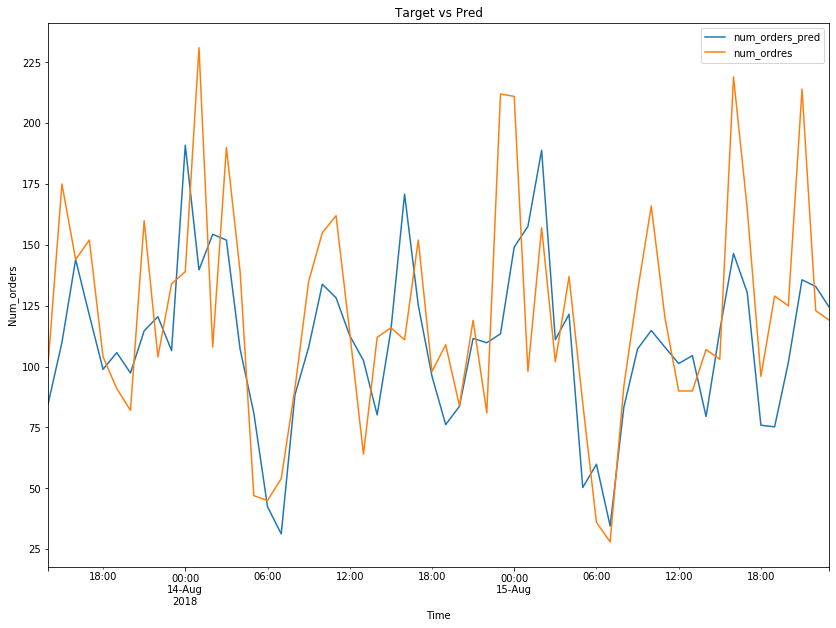

In [43]:
ax=data_pred_cbr['2018-07-30':'2018-08-15'].plot()
data_target['2018-07-30':'2018-08-15'].plot(ax=ax, figsize=(14, 10))
plt.title('Target vs Pred')
plt.xlabel('Time')
plt.ylabel('Num_orders')

# Вывод

Данные состоят из 26496 строк, период наблюдений с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.
Столбец с количеством заказов представлен с частотой наблюдений каждые 10 минут.
Пропуски отсутствуют. Судя по графику, количество заказов растет с начала наблюдений.  

Прослеживается тренд на увеличение количества заказов.
Количество заказов максимально в пт и пн, а минимально во вт и вск.
Мы четко видим активность клиентов в течение рабочего дня и снижение в ночное время.  

| Model        | RMSE|
| ------------- |------------------|
| CatBoost |46|
| LGBMRegressor |47|
| RandomForestRegressor |48|
| LinearRegression |54|
| DecisionTreeRegressor |64|  

Наилучший результат метрики RMSE показала модель **CatBoost**.  
Метрика RMSE указывает нам на то, что модель выдает ошибку на +/-46 машин в час.  

Сравнив предсказания модели с действительными данными получили следующий вывод:  
1. В ~70 % случаев наша модель предсказывает меньшее количество машин со средним значением ошибки ~ 40 заказов,
2. В ~30 % случаев модель предскаызвает большее количесвто машин со средним значением ошибки ~ 22 заказов.

С точки зрения бизнеса, чаще мы будем получать дефецит машин на линии и как следствие - потерю прибыли.  

Требуется оценить размер упущенной прибыли и затрат на вывод дополнительных водителей на линию, с учетом необходимых бизнес результатов.  